In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split


# Custom modules and packages
import params.siamese
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test

## Prepare data

In [2]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_test.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=params.siamese.BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=params.siamese.BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=params.siamese.BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [3]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [4]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (504 samples)
15.0 % of the data for validation (108 samples)
15.0 % of the data for testing (108 samples)


## GPU?

In [5]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [6]:
# Create a model
model = SiameseNetwork(nb_input_features=3).to(device=device)

In [7]:
# Create a loss function
criterion = SiameseLoss(margin=params.siamese.MARGIN).to(device=device)

In [8]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=params.siamese.LEARNING_RATE,
                      momentum=params.siamese.MOMENTUM,
                      weight_decay=params.siamese.WEIGHT_DECAY)

# Create tensors to store the loss values
loss_values = torch.zeros(2, params.siamese.NB_EPOCHS)

# Loop over the epochs
for epoch in range(params.siamese.NB_EPOCHS):
    
    # Training
    train_loss = train(model,
                       device,
                       train_loader,
                       optimizer,
                       criterion,
                       epoch)
    
    # Validation
    val_loss = validate(model,
                        device,
                        val_loader,
                        criterion,
                        epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss

Epoch 0 [val]: 100%|██████████| 36/36 [00:00<00:00, 46.82batch/s, batch_loss=0.903]


Train loss:  1.7301210072778521
Validation loss:  1.4360022048155467


Epoch 1 [val]: 100%|██████████| 36/36 [00:00<00:00, 47.12batch/s, batch_loss=1.27] 


Train loss:  1.418711558605234
Validation loss:  1.313648972246382


Epoch 2 [val]: 100%|██████████| 36/36 [00:00<00:00, 49.69batch/s, batch_loss=1.69] 


Train loss:  1.3637586899900012
Validation loss:  1.2780713281697698


Epoch 3 [val]: 100%|██████████| 36/36 [00:00<00:00, 45.51batch/s, batch_loss=2.93] 


Train loss:  1.341998319540705
Validation loss:  1.2644038498401642


Epoch 4 [val]: 100%|██████████| 36/36 [00:00<00:00, 50.45batch/s, batch_loss=1.97] 


Train loss:  1.3309945648624784
Validation loss:  1.2537731611066394


Epoch 5 [val]: 100%|██████████| 36/36 [00:00<00:00, 49.92batch/s, batch_loss=1.53] 


Train loss:  1.322021442775925
Validation loss:  1.2456375451551542


Epoch 6 [val]: 100%|██████████| 36/36 [00:00<00:00, 44.28batch/s, batch_loss=1.58]  


Train loss:  1.3159637117447953
Validation loss:  1.2404918672723904


Epoch 7 [val]: 100%|██████████| 36/36 [00:00<00:00, 50.24batch/s, batch_loss=0.257]


Train loss:  1.3119166503027027
Validation loss:  1.2372702120078936


Epoch 8 [val]: 100%|██████████| 36/36 [00:00<00:00, 45.76batch/s, batch_loss=1.9]  


Train loss:  1.3102046239766336
Validation loss:  1.2358979524837599


Epoch 9 [val]: 100%|██████████| 36/36 [00:00<00:00, 50.65batch/s, batch_loss=0]    

Train loss:  1.3091409234330058
Validation loss:  1.23433837460147


### Visualization

Text(0.5, 0, 'Epoch')

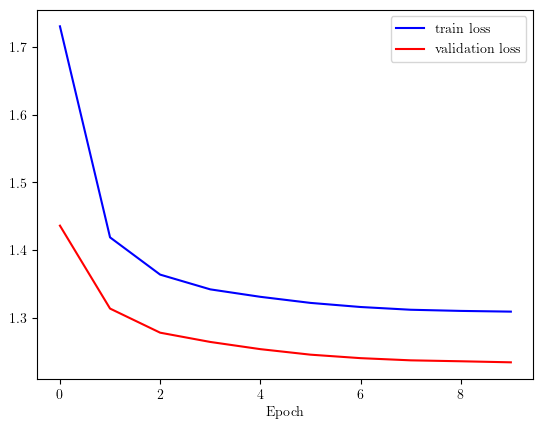

In [9]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [10]:
# Test the model
test_loss = test(model,
                 device,
                 test_loader,
                 criterion)

print("Test loss: ", test_loss)

Test loss:  1.2636084391011133


## Save model parameters

In [ ]:
# Save the model parameters
torch.save(model.state_dict(), "siamese.params")